In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import path
import warnings
assert path.exists("solver") 
assert path.exists("solver/utils") 

In [3]:
with warnings.catch_warnings():  # warning still somehow pierces through, so I cleared the cell output
    import tensorflow as tf  # tf 2.x
    import tensornetwork as tn
    tn.set_default_backend("tensorflow")
    
import numpy as np
import QGOpt as qgo
import math
import matplotlib.pyplot as plt

import solver.utils.general_utils as util
import solver.noising_tools as ns
import solver.utils.channel_utils as c_util
import solver.file_management as fm
import solver.circuits_generation as cg

from solver.QCCalc import QCEvaluator
from solver.experiments import ExperimentConductor, assert_psi2_eq_1
from solver.utils.misc import unwrap_dict, NconTemplate, INT, FLOAT, COMPLEX, ID_GATE
from solver.QCSolver import QGOptSolver, get_complex_channel_form, QGOptSolverDebug

2024-02-06 07:49:45.711094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 07:49:46.392924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-06 07:49:47.623359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-06 07:49:47.627395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

### Quantum gates preparation

In [4]:
Rx = util.create_unitary_rotation_x(math.pi/2)
Ry = util.create_unitary_rotation_y(math.pi/2)
print('Rx:', Rx.numpy().round(3))
print('Ry:', Ry.numpy().round(3))

E = tf.eye(2, dtype=COMPLEX)

Rx: [[0.707+0.j    0.   -0.707j]
 [0.   -0.707j 0.707+0.j   ]]
Ry: [[ 0.707+0.j -0.707+0.j]
 [ 0.707+0.j  0.707+0.j]]


In [5]:
def create_unitary_rotation_rxx(angle: float = 0.25) -> tf.Tensor:
    chi = angle * math.pi
    
    nastya_s_matrix = np.array([
        [np.cos(chi), 0, 0, -1j*np.sin(chi)],
        [0, np.cos(chi), -1j*np.sin(chi), 0],
        [0, -1j*np.sin(chi), np.cos(chi), 0],
        [-1j*np.sin(chi), 0, 0, np.cos(chi)]
    ])
    
    return tf.convert_to_tensor(nastya_s_matrix, dtype=COMPLEX)

RXX_44 = create_unitary_rotation_rxx()

RXX_44.numpy()

array([[0.70710678+0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.        -0.70710678j],
       [0.        +0.j        , 0.70710678+0.j        ,
        0.        -0.70710678j, 0.        +0.j        ],
       [0.        +0.j        , 0.        -0.70710678j,
        0.70710678+0.j        , 0.        +0.j        ],
       [0.        -0.70710678j, 0.        +0.j        ,
        0.        +0.j        , 0.70710678+0.j        ]])

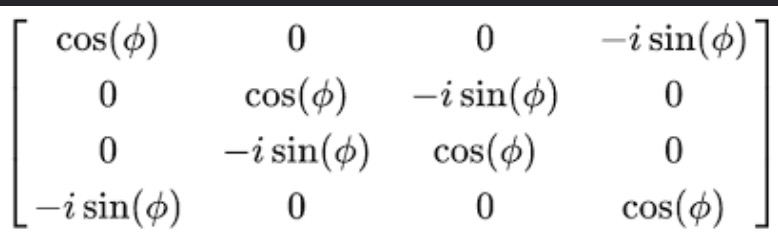

Now it is time to convert these unitary operators to quantum channels. Two-qubit gates need to be reshaped first.

In [6]:
RXX = util.convert_44_to_2222(RXX_44)

Rx_channel = c_util.convert_1qmatrix_to_channel(Rx)
Ry_channel = c_util.convert_1qmatrix_to_channel(Ry)
E_channel = c_util.convert_1qmatrix_to_channel(E)
RXX_channel = c_util.convert_2qmatrix_to_channel(RXX)

Now we need to make set of channels from this. The recommended order is to fill all single-qubit gates, then internal identity gate (**this is important**), then all two-qubit gates.

In [7]:
default_pure_channels = {'Rx':Rx_channel,
                         'Ry':Ry_channel,
                         'M': E_channel,
                         ID_GATE:E_channel,
                          'P':E_channel,
                         'RXX': RXX_channel}                        

### Circuits preparation

In [8]:
NUM_QUBITS = 2

gates_labels = list(default_pure_channels.keys())
gates_labels.remove(ID_GATE)

gen = cg.DataGenerator(qubits_num=NUM_QUBITS,
                       gates_names=gates_labels, # ['Rx', 'Ry', 'M', 'CX']
                       single_qub_gates_num=4,
                       two_qub_gates_num=1)

In [9]:
def apply_vi(n_q, option):
    if option == 0:
        return []

    return [f'Rx_{n_q}']
    
def apply_ui(n_q, option):
    ret = []
    
    if option in [1, 3]:
        ret += [f'Rx_{n_q}']
    elif option == 2:
        ret += [f'Ry_{n_q}']
        
    if option == 3:
        ret += [f'Rx_{n_q}']

    return ret
    

def generate_u_v_circuits():
    circs = []
    
    for t in range(0, 4):
        for k in range(0, 4):
            for j in range(0, 3):
                for l in range(0, 3):
                    new_circ = []
                    new_circ = new_circ + apply_ui(0, t) + apply_ui(1, k)
                    
#                     CG.emit_xx([0, 1], 0.25)
                    new_circ.append("RXX_0_1")
                        
                    new_circ = new_circ + apply_vi(0, j) + apply_ui(1, l)
            
                    new_circ = new_circ + ['M_0', 'M_1']
                    
                    circs.append(new_circ)
                    
    return circs

In [10]:
circs = [['M_0', 'M_1'],
         ['Rx_0', 'Rx_0', 'Rx_1', 'Rx_1', 'M_0', 'M_1'],
         ['Rx_0', 'Rx_0', 'M_0', 'M_1'],
         ['Rx_1', 'Rx_1', 'M_0', 'M_1']]

circs += generate_u_v_circuits()

print(len(circs))

148


In [11]:
circs

[['M_0', 'M_1'],
 ['Rx_0', 'Rx_0', 'Rx_1', 'Rx_1', 'M_0', 'M_1'],
 ['Rx_0', 'Rx_0', 'M_0', 'M_1'],
 ['Rx_1', 'Rx_1', 'M_0', 'M_1'],
 ['RXX_0_1', 'M_0', 'M_1'],
 ['RXX_0_1', 'Rx_1', 'M_0', 'M_1'],
 ['RXX_0_1', 'Ry_1', 'M_0', 'M_1'],
 ['RXX_0_1', 'Rx_0', 'M_0', 'M_1'],
 ['RXX_0_1', 'Rx_0', 'Rx_1', 'M_0', 'M_1'],
 ['RXX_0_1', 'Rx_0', 'Ry_1', 'M_0', 'M_1'],
 ['RXX_0_1', 'Rx_0', 'M_0', 'M_1'],
 ['RXX_0_1', 'Rx_0', 'Rx_1', 'M_0', 'M_1'],
 ['RXX_0_1', 'Rx_0', 'Ry_1', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Rx_1', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Ry_1', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Rx_0', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Rx_0', 'Rx_1', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Rx_0', 'Ry_1', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Rx_0', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Rx_0', 'Rx_1', 'M_0', 'M_1'],
 ['Rx_1', 'RXX_0_1', 'Rx_0', 'Ry_1', 'M_0', 'M_1'],
 ['Ry_1', 'RXX_0_1', 'M_0', 'M_1'],
 ['Ry_1', 'RXX_0_1', 'Rx_1', 'M_0', 'M_1'],
 ['Ry_1', 'RXX_0_1',

In [17]:
np.random.seed(1337)

ncon_tmpls = gen.get_tmpl_dict_from_human_circs(circs)

for idx in np.random.choice(np.arange(len(circs)), 3):
    print(f'A quantum circuit with very simple "human" representation \n{circs[idx]}'
    f'\nhas a very scary tensor network template \n{ncon_tmpls[str(idx)]}')

A quantum circuit with very simple "human" representation 
['Ry_0', 'Rx_1', 'RXX_0_1', 'Rx_0', 'Rx_1', 'M_0', 'M_1']
has a very scary tensor network template 
[[2, 1, 9, 0, 1, 4, 5], [[3, 1], [4, 2], [6, 5, 4, 3], [7, 5], [8, 6], [-1, 7], [-2, 8]], [3, 4, 5, 6, 7, 8], [-1, -2]]
A quantum circuit with very simple "human" representation 
['Ry_0', 'Rx_1', 'RXX_0_1', 'Rx_0', 'Ry_1', 'M_0', 'M_1']
has a very scary tensor network template 
[[2, 1, 9, 0, 3, 4, 5], [[3, 1], [4, 2], [6, 5, 4, 3], [7, 5], [8, 6], [-1, 7], [-2, 8]], [3, 4, 5, 6, 7, 8], [-1, -2]]
A quantum circuit with very simple "human" representation 
['Rx_0', 'Rx_0', 'RXX_0_1', 'Ry_1', 'M_0', 'M_1']
has a very scary tensor network template 
[[0, 0, 9, 3, 4, 5], [[3, 1], [4, 3], [6, 5, 2, 4], [7, 6], [-1, 5], [-2, 7]], [3, 4, 5, 6, 7], [-1, -2]]


In [19]:
noise_cfg = []

with warnings.catch_warnings():
    exp_test = ExperimentConductor(pure_channels_set=default_pure_channels,
                                   noise_cfg=noise_cfg,
                                   exp_name='zh_test',
                                   qubits_num=NUM_QUBITS,
                                   lr=0.002,  
                                   lmbd1=100,
                                   lmbd2=100,
                                   iterations=300,
                                   sample_size=8192)

In [20]:
QC_t = QGOptSolverDebug(qubits_num=NUM_QUBITS,
                        single_qub_gates_names={'Rx', 'Ry', 'M', 'P'},
                        two_qub_gates_names={'RXX'},
                        pure_channels_set=default_pure_channels,
                        compress_samples=True,
                        noise_params=exp_test.noise_params,
                        noise_iter0=0.07)

assert len(QC_t.tn_templates) == 0

for name, tmpl in ncon_tmpls.items():
    QC_t.add_circuit(tn_template=tmpl, name=name)
    
assert len(QC_t.tn_templates) == 148
    
# QC_t.generate_all_samples(v=True, smpl_size=exp_test.sample_size)

Estimated set is generated from pure channels by applying noise parameters [0.07 0.   0.  ]


In [21]:
with open("MS_tomography3.npy", "rb") as a_file:
    BIG_TENSOR = np.load(a_file)
    
BIG_TENSOR.shape 

(148, 2, 2048)

In [22]:
class ReadoutAnalyzer():
    def __init__(self, parent=None, cfg=None, readout_matrix=None, correct=False):
        super().__init__()
        self.name = 'ReadoutAnalyzer'
        self.parent = parent
        self.cfg = cfg
        self.calib_data = None
        self.calib_len = 0
        self.calib_matrix = None
        self.clear_data()
        self.d = 2
        self.ion_num = 0
        self.averages = 0
        if correct:
            self.initialize_correction(readout_matrix)

    """"""
    def initialize_correction(self, readout_matrix=None):
        if readout_matrix is None:
            config_file = Path("readout.cfg")
            try:
                with config_file.open() as f:
                    self.calib_data = json.load(f)
            except (json.JSONDecodeError, OSError) as err:
                print("Failed to open/read readout config file: ", err)
                return
        else:
            self.calib_data = readout_matrix

        self.calib_len = len(self.calib_data)
        self.calib_matrix = np.ones((2**self.calib_len, 2**self.calib_len))
        for rstate in range(2 ** self.calib_len):
            for mstate in range(2 ** self.calib_len):
                for ion in range(self.calib_len):
                    rsd = (rstate >> ion) & 1
                    msd = (mstate >> ion) & 1
                    if rsd == msd:
                        self.calib_matrix[mstate, rstate] *= self.calib_data[ion][rsd]
                    else:
                        self.calib_matrix[mstate, rstate] *= 1 - self.calib_data[ion][rsd]
        self.calib_matrix = np.linalg.inv(self.calib_matrix)

    def clear_data(self, level = 0):
        self.d = None
        self.ion_num = None
        self.averages = None
        if level <= 0:
            self.data = None
        if level <= 1:
            self.data_states = None
        if level <= 2:
            self.register_state = None
        if level <= 3:
            self.diagonal = None
        if level <= 4:
            self.corrected_diagonal = None

    def set_data(self, data):
        self.clear_data()
        self.data = np.array(data)

    def set_thresholds(self, thresholds):
        self.thresholds = thresholds

    """Returns for each run and ion its state"""
    def get_outcomes_from_data(self, data=None, thresholds=None):
        if data is not None:
            self.set_data(data)
        if thresholds is not None:
            self.set_thresholds(thresholds)

        """If we have already calculated it -- just give it back"""
        if self.data_states is not None:
            return self.data_states

        if self.data is None or self.thresholds is None:
            raise Exception("Data or thresholds are not specified for readout analyzer!")

        """Clear higher level results"""
        self.clear_data(level=1)

        #  Decide if work with qudits or qubits
        if len(self.data.shape) == 3:
            self.d = self.data.shape[1] + 1
        else:
            self.d = 2

        self.ion_num = self.data.shape[0]
        self.averages = self.data.shape[-1]
        self.data_states = np.empty((self.ion_num, self.averages), dtype=int)
        for ion in range(self.ion_num):
            if self.d == 2:
                #  Discriminate datasets
                self.data_states[ion, :] = np.array(np.array(self.data[ion]) < self.thresholds[ion], dtype=int)
            else:
                for point in range(self.averages):
                    self.data_states[ion, point] = 0
                    for state in range(self.d-1):
                        if self.data[ion, state, point] >= self.thresholds[ion]:
                            break
                        self.data_states[ion, point] += 1
        return self.data_states

    def get_register_state(self, data_states=None, d=None, data=None, thresholds=None):
        if data_states is not None:
            self.data_states = data_states
            self.clear_data(level=2)
        else:
            if data is not None:
                self.set_data(data)
            if thresholds is not None:
                self.set_thresholds(thresholds)

        if d is not None:
            self.d = d

        if self.register_state is not None:
            return self.register_state

        # retrieve states data
        self.get_outcomes_from_data()

        if self.data_states is None:
            raise Exception("Output states are not provided to readout analyzer!")


        self.ion_num = self.data_states.shape[0]
        self.averages = self.data_states.shape[1]

        self.register_state = np.zeros(self.averages, dtype=int)
        # print(self.d)
        # print(self.ion_num)
        # print(self.averages)
        for ion in range(self.ion_num):
            # print(self.data_states[ion] * self.d**(self.ion_num - 1 - ion))
            self.register_state += self.data_states[ion] * self.d**(self.ion_num - 1 - ion)

        return self.register_state


    def get_uncorrected(self, register_state=None, averages=None, ion_num=None, data_states=None, d=None, data=None,
                        thresholds=None):
        if register_state is not None:
            self.register_state = register_state
            self.clear_data(level=3)
        else:
            if data is not None:
                self.set_data(data)
            if thresholds is not None:
                self.set_thresholds(thresholds)
            if data_states is not None:
                self.data_states = data_states
                self.clear_data(level=2)

        if d is not None:
            self.d = d
        if ion_num is not None:
            self.ion_num = ion_num
        if averages is not None:
            self.averages = averages

        if self.diagonal is not None:
            return self.diagonal

        # retrieve states data
        self.get_register_state()

        if self.register_state is None:
            raise Exception("Register states are not provided to readout analyzer!")

        vals, counts = np.unique(self.register_state, return_counts=True)
        self.diagonal = np.zeros(self.d ** self.ion_num)
        for i, val in enumerate(vals):
            self.diagonal[val] = counts[i] / self.averages

        return self.diagonal

    """Do not use! Not upgraded yet!"""
    def apply_correction(self, measured_diagonal):
        ions_num = len(measured_diagonal)
        if ions_num != 2**self.calib_len:
            print("Calibrations data length is smaller than current number of channels: ")
            return None
        corrected_diagonal = np.matmul(self.calib_matrix, measured_diagonal)
        return corrected_diagonal

    def analyze(self, data, thresholds):
        measured_diagonal = self.get_uncorrected(data, thresholds)
        corrected_diagonal = np.matmul(self.calib_matrix, measured_diagonal)
        return corrected_diagonal

In [23]:
thresholds = [3, 3]  # Nastya's magic

ra = ReadoutAnalyzer()

OUTCOMES = [ra.get_outcomes_from_data(data=BIG_TENSOR[i], thresholds=thresholds) for i in range(len(BIG_TENSOR))]

In [24]:
OUTCOMES[0].shape

(2, 2048)

In [31]:
DICT_COMPRESSED_SAMPLES = {}
QC_t.samples_compressed = {}

for idx, outcome in enumerate(OUTCOMES):
    bs_code = outcome[0] * 2 + outcome[1]
    bincount = np.bincount(bs_code, minlength=4)
    QC_t.samples_compressed[str(idx)] = tf.convert_to_tensor(bincount, dtype=tf.float64)

In [32]:
QC_t.samples_compressed

{'0': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([2013.,   16.,   19.,    0.])>,
 '1': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([   2.,   36.,   38., 1972.])>,
 '2': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([2.6e+01, 1.0e+00, 2.0e+03, 2.1e+01])>,
 '3': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([  43., 1992.,    0.,   13.])>,
 '4': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([984., 146., 148., 770.])>,
 '5': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([549., 576., 490., 433.])>,
 '6': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([616., 580., 427., 425.])>,
 '7': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([581., 443., 555., 469.])>,
 '8': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([480., 559., 586., 423.])>,
 '9': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([869., 117., 141., 921.])>,
 '10': <tf.Tensor: shape=(4,), dtype=float64, numpy=array([610., 429., 568., 441.])>,
 '11': <tf.Tensor: shape=(4,), dtype=flo

Now we need to setup our manifold for quantum channels optimization and grab optimizer itself from `QGOpt` library.

In [33]:
manif = qgo.manifolds.ChoiMatrix()
opt_t = qgo.optimizers.RAdam(manif, exp_test.lr)

In [34]:
loss_dynamics_t, norms_dict, _ = QC_t.train_optimizer(opt=opt_t,
                                                      lmbd1=exp_test.lmbd1,
                                                      lmbd2=exp_test.lmbd2,
                                                      iters=300,
                                                      v=1,
                                                      fid_ctr=1, # we'd like to calculate fidelities every step
                                                      norm_ctr=-1)  # we don't calculate L1 norms here

0 out of 300 iterations passed
30 out of 300 iterations passed
60 out of 300 iterations passed
90 out of 300 iterations passed
120 out of 300 iterations passed
150 out of 300 iterations passed
180 out of 300 iterations passed
210 out of 300 iterations passed
240 out of 300 iterations passed
270 out of 300 iterations passed


We can look at our loss dymamics to see that learning process was OK:

Text(0.5, 1.0, 'learning curve')

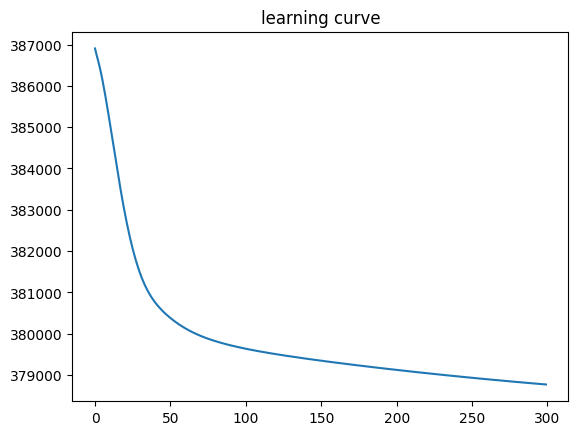

In [60]:
plt.plot(loss_dynamics_t)  
plt.title('learning curve')

## Results

The debug version of the solver has the ability to extract norms $\left( \| {\bf G}^{\rm est}(l,t) - {\bf G}^{\rm true}(l,t) \|, \; \| {\bf G}^{\rm est}(l,t) - {\bf G}^{\rm ideal}(l,t) \| \right) $ during each iteration of algorithm. These norms will provide us with beautiful graphs. For most of the gates, diamond norm in extracted, and for measurement gate ${\sf M}$ it is POVM norm (see article for details).  

Let's plot these norms vs. algorithm iteration number to prove that our algorithm did a good job. Remember, since we were the ones who generated the noise, we have information about norms between true vestions and estimated versions of quantum gates $\| {\bf G}^{\rm est}(l,t) - {\bf G}^{\rm true}(l,t) \| $. Of course, in real experiment we would be able to see only norms between ideal and estimated versions.

First, we extract the norms between true and ideal quantum gates; these norms will appear as horizontal lines a. k. a. answers. Our goal is to make ideal-estimated norm $\| {\bf G}^{\rm est}(l,t) - {\bf G}^{\rm ideal}(l,t) \| $ as close as possible to true-ideal norm $\| {\bf G}^{\rm true}(l,t) - {\bf G}^{\rm ideal}(l,t) \| $. This process is related to minimizing the true-estimated norm. Note that unlike in the article, here the number of circuis stays the same! X axis represents the number of iterations which is just a hyperparameter in the big experiment.

In [37]:
from collections import defaultdict
HLINES = defaultdict(list)

for label in QC_t.hidden_gates_dict:
    sublist = QC_t.hidden_gates_dict[label]
    for idx, gate in enumerate(sublist):
        if label == 'RXX':
            HLINES[label].append(util.diamond_norm_2q(gate, default_pure_channels[label]))
        elif label == 'M':
            HLINES[label].append(util.get_povm_dist(gate, default_pure_channels[label]))
        elif label == 'P':
            HLINES[label].append(util.get_prep_dist(gate, default_pure_channels[label]))
#             HLINES[label].append(1 - tf.math.real(
#                 util.fidel_calc_1q(gate, default_pure_channels[label])
#             ))
        else:
            HLINES[label].append(util.diamond_norm_1q(gate, default_pure_channels[label]))
            
COLORS = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:gray']

### Plotting norms

In [38]:
def plot_diamond_norms(ax1, ax2):
    colors_idx = [0, 0]
    
    for key in norms_dict.keys():
        label, idx, norm_type = key

        if label in ['Rx', 'Ry', 'RXX']:
            if label == 'RXX' and idx == 1:
                continue
                
            if norm_type == 'i':
                ax1.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[0]])
                ax1.axhline(y=HLINES[label][idx],
                            color=COLORS[colors_idx[0]],
                            linestyle=':')
                colors_idx[0] += 1

            else:
                ax2.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[1]])
                colors_idx[1] += 1
            
    ax1.set_title('Diamond norm(ideal, est)', {"size":18})
    ax1.set_xlabel('Algorithm iteration number', {"size":16})

    ax2.set_title('Diamond norm(true, est)', {"size":18})
    ax2.set_xlabel('Algorithm iteration number', {"size":16})

    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
        
        # ax.set_ylim(0.92, 0.98)
        
def plot_povm_norms(ax1, ax2):
    colors_idx = [0, 0]
    
    for key in norms_dict.keys():
        label, idx, norm_type = key

        if label == 'M':
            if norm_type == 'i':
                ax1.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[0]])
                ax1.axhline(y=HLINES[label][idx],
                            color=COLORS[colors_idx[0]],
                            linestyle=':')
                colors_idx[0] += 1

            else:
                ax2.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[1]])
                colors_idx[1] += 1
        elif label == 'P':
            if norm_type == 'i':
                ax1.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[0]])
                ax1.axhline(y=HLINES[label][idx],
                            color=COLORS[colors_idx[0]],
                            linestyle=':')
                colors_idx[0] += 1

            else:
                ax2.plot(np.abs(norms_dict[label, idx, norm_type]),
                         label=f'{label}{idx}',
                         color=COLORS[colors_idx[1]])
                colors_idx[1] += 1        
            
            
    ax1.set_title('SPAM norm(ideal, est)', {"size":18})
    ax1.set_xlabel('Algorithm iteration number', {"size":16})

    ax2.set_title('SPAM norm(true, est)', {"size":18})
    ax2.set_xlabel('Algorithm iteration number', {"size":16})

    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
        
        # ax.set_ylim(0.92, 0.98)

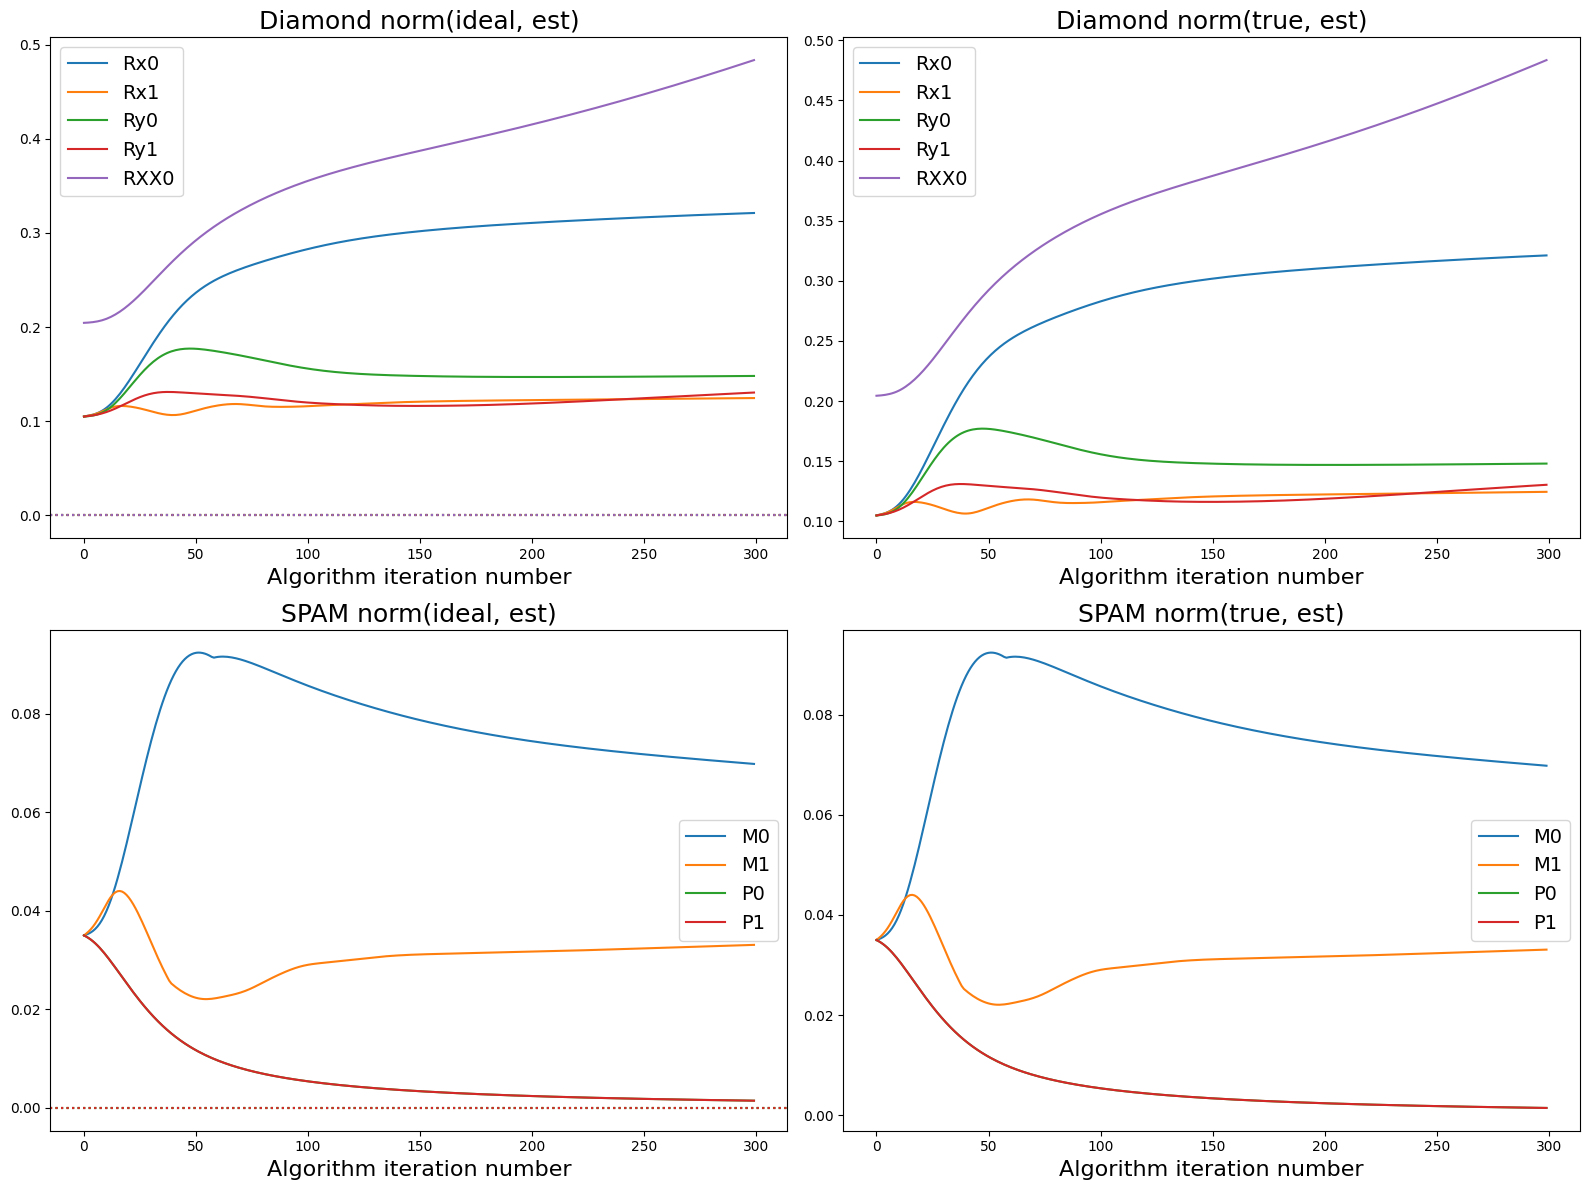

In [39]:
fig, axarr = plt.subplots(2, 2, figsize=(16, 12))
ax1, ax2, ax3, ax4 = [a for sublist in axarr for a in sublist]
plot_diamond_norms(ax1, ax2)
plot_povm_norms(ax3, ax4)
fig.tight_layout()
plt.show()

### Post-procesing, saving and loading data

You may have a need to conduct experiments on different devices. Or just conveniently save the results somewhere in order to access them later. Fortunately, there's a file `solver/file_management.py` dedicated to such tasks. The code there should be simple and easy to read.

The most important information after an algorithm has done its job now resides in the member `estimated_gates_dict` of a `Solver` class. However, we need to convert it to complex channel form for better readability.

In [40]:
dict_result = get_complex_channel_form(QC_t.estimated_gates_dict)
# print(dict_result)

These are numerical estimations on gates of a quantum processor. Single-qubit gates or SPAM operations have $n$ versions - one for each qubit. Two-qubit gates have $n (n-1)$ versions - one for each pair of qubits. We can save a dict containing this information into a .pickle file, and then extract these tensors somewhere else.

In [41]:
fm.save_tensors_to_file(dict_result, ['tomo_exp'], prefix_args=1)

The folder `data\tomo-tutorial` should now appear, with a .pickle file containing the results of the experiment. Of course, you can instantly load them back:

In [42]:
reuploaded_dict = fm.import_tensors_from_file(['tomo_exp'], prefix_args=1)
assert reuploaded_dict.keys() == dict_result.keys()
for key in reuploaded_dict:
    assert tf.abs(tf.linalg.norm(reuploaded_dict[key] - dict_result[key])) < 1e-10

Sometimes it is desirable to work with Choi matrices which are familiar to many people instead of some quantum channels denoted in some article. There are ways to convert the gate set into Choi matrices:

In [45]:
choi1 = util.choi_swap_1qchannel(dict_result['Rx'][0])
choi2 = util.choi_swap_2qchannel(dict_result['CX'][0])

In [48]:
dict_choi = {}

for k, v in dict_result.items():
    ZXC = []
    
    for tt in v:
        if k != 'RXX':
            ZXC.append(util.choi_swap_1qchannel(tt))
        else:
            ZXC.append(util.choi_swap_2qchannel(tt))
        
    dict_choi[k] = tf.concat([ZXC], axis=0)

dict_choi

{'Rx': <tf.Tensor: shape=(2, 4, 4), dtype=complex128, numpy=
 array([[[ 0.47873649+0.j        , -0.09888974+0.40814059j,
           0.04677812+0.46762117j,  0.42525763+0.06406098j],
         [-0.09888974-0.40814059j,  0.49059809+0.j        ,
           0.42969539-0.12092104j, -0.01376522-0.43826146j],
         [ 0.04677812-0.46762117j,  0.42969539+0.12092104j,
           0.52126351+0.j        ,  0.09888974-0.40814059j],
         [ 0.42525763-0.06406098j, -0.01376522+0.43826146j,
           0.09888974+0.40814059j,  0.50940191+0.j        ]],
 
        [[ 0.52070946+0.j        ,  0.01795731+0.46810473j,
           0.00231642+0.48799972j,  0.48772956-0.0153364j ],
         [ 0.01795731-0.46810473j,  0.45829177+0.j        ,
           0.45068284+0.00330179j, -0.01896336-0.46730634j],
         [ 0.00231642-0.48799972j,  0.45068284-0.00330179j,
           0.47929054+0.j        , -0.01795731-0.46810473j],
         [ 0.48772956+0.0153364j , -0.01896336+0.46730634j,
          -0.01795731+0.46810

In [50]:
from solver.utils.testing import is_choi

In [54]:
is_choi(dict_result['Rx'][0] / tf.constant(2, dtype=COMPLEX))

Eig (-0.00977366029354676+0.43616559288555357j) has too big imaginary part


False

In [55]:
is_choi(dict_choi['Rx'][1] / tf.constant(2, dtype=COMPLEX))

True

In [58]:
is_choi(dict_choi['RXX'][1] / tf.constant(4, dtype=COMPLEX))

True

In [59]:
fm.save_tensors_to_file(dict_choi, ['tomo_exp'], prefix_args=1)